In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

print("Imports OK")

Imports OK


In [2]:
from google.colab import files
uploaded = files.upload()

Saving eil76.tsp to eil76.tsp


In [5]:


# load eil76.tsp (tsplib euclidean tsp) and return the city coordinates
def load_tsplib_euc2d(path):
    """returns a list of (x, y) coords for each city"""
    coords = []
    with open(path, "r") as f:
        lines = f.readlines()

    node_section = False
    for line in lines:
        line = line.strip()
        if line == "" or line.upper().startswith("EOF"):
            continue
        if line.upper().startswith("NODE_COORD_SECTION"):
            node_section = True
            continue
        if not node_section:
            continue

        parts = line.split()
        if len(parts) >= 3:
            # format: index  x  y
            _, x, y = parts[:3]
            coords.append((float(x), float(y)))

    return coords

# function to build the distance matrix
def compute_distance_matrix(coords):
    """build a full distance matrix using rounded euclidean distance"""
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        x1, y1 = coords[i]
        for j in range(n):
            if i == j:
                continue
            x2, y2 = coords[j]
            dist[i, j] = round(math.hypot(x1 - x2, y1 - y2))
    return dist

# tour length helper (used in both ga and aco)
def tour_length(tour, dist_matrix):
    total = 0.0
    for i in range(len(tour)):
        j = (i + 1) % len(tour)
        total += dist_matrix[tour[i], tour[j]]
    return total

# simple plot helper to visualize the cities
def plot_cities(coords):
    xs = [c[0] for c in coords]
    ys = [c[1] for c in coords]
    plt.figure()
    plt.scatter(xs, ys)
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, str(i), fontsize=7)
    plt.title("eil76 city locations")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# simple plot helper to visualize a tour
def plot_tour(tour, coords, title="best tour"):
    xs = [coords[i][0] for i in tour] + [coords[tour[0]][0]]
    ys = [coords[i][1] for i in tour] + [coords[tour[0]][1]]
    plt.figure()
    plt.plot(xs, ys, marker="o")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

print("setup cell ran correctly")

setup cell ran correctly


eil76.tsp  sample_data
cities: 76
distance matrix shape: (76, 76)


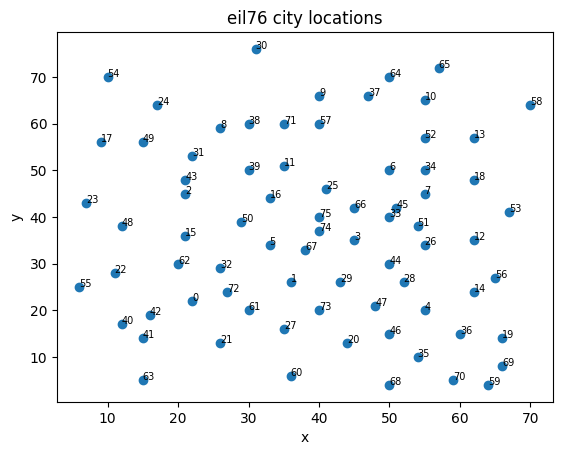

In [6]:
# check that the file is really here
!ls

coords = load_tsplib_euc2d("eil76.tsp")
distance_matrix = compute_distance_matrix(coords)

print(f"cities: {len(coords)}")
print("distance matrix shape:", distance_matrix.shape)

# visualize the cities
plot_cities(coords)

In [7]:
# genetic algorithm for tsp

num_cities = len(coords)

def create_random_tour():
    # make a random permutation of all cities
    tour = list(range(num_cities))
    random.shuffle(tour)
    return tour

def initial_population(pop_size):
    # create the first generation of random tours
    return [create_random_tour() for _ in range(pop_size)]

def tournament_selection(population, fitnesses, k=3):
    # pick k random individuals and return the best one
    indices = random.sample(range(len(population)), k)
    best_idx = min(indices, key=lambda idx: fitnesses[idx])
    return population[best_idx]

def ordered_crossover(parent1, parent2):
    # ordered crossover (ox) keeps the relative order of cities
    n = len(parent1)
    a, b = sorted(random.sample(range(n), 2))
    child = [None] * n

    # copy a slice from parent1
    child[a:b+1] = parent1[a:b+1]

    # fill the remaining positions with cities from parent2 in order
    p2_idx = 0
    for i in range(n):
        if child[i] is not None:
            continue
        while parent2[p2_idx] in child:
            p2_idx += 1
        child[i] = parent2[p2_idx]
    return child

def swap_mutation(tour, mutation_rate):
    # randomly swap cities with a given probability
    tour = tour[:]  # copy
    for i in range(len(tour)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(tour) - 1)
            tour[i], tour[j] = tour[j], tour[i]
    return tour

def run_ga(
    dist_matrix,
    pop_size=80,
    generations=400,
    crossover_rate=0.9,
    mutation_rate=0.03,
    tournament_k=3
):
    # make initial population
    population = initial_population(pop_size)
    fitnesses = [tour_length(ind, dist_matrix) for ind in population]

    best_lengths = []
    best_tour = None
    best_len = float("inf")

    for gen in range(generations):
        # update current best
        for i, ind in enumerate(population):
            if fitnesses[i] < best_len:
                best_len = fitnesses[i]
                best_tour = ind[:]

        best_lengths.append(best_len)

        # build next generation
        new_population = []
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses, k=tournament_k)
            parent2 = tournament_selection(population, fitnesses, k=tournament_k)

            if random.random() < crossover_rate:
                child = ordered_crossover(parent1, parent2)
            else:
                child = parent1[:]

            child = swap_mutation(child, mutation_rate)
            new_population.append(child)

        population = new_population
        fitnesses = [tour_length(ind, dist_matrix) for ind in population]

        if gen % 50 == 0 or gen == generations - 1:
            print(f"generation {gen+1}/{generations} - best length so far: {best_len}")

    return best_tour, best_len, best_lengths

best_tour_ga, best_len_ga, history_ga = run_ga(distance_matrix)
print("ga best length:", best_len_ga)

generation 1/400 - best length so far: 2234.0
generation 51/400 - best length so far: 1876.0
generation 101/400 - best length so far: 1792.0
generation 151/400 - best length so far: 1736.0
generation 201/400 - best length so far: 1736.0
generation 251/400 - best length so far: 1736.0
generation 301/400 - best length so far: 1736.0
generation 351/400 - best length so far: 1736.0
generation 400/400 - best length so far: 1736.0
ga best length: 1736.0


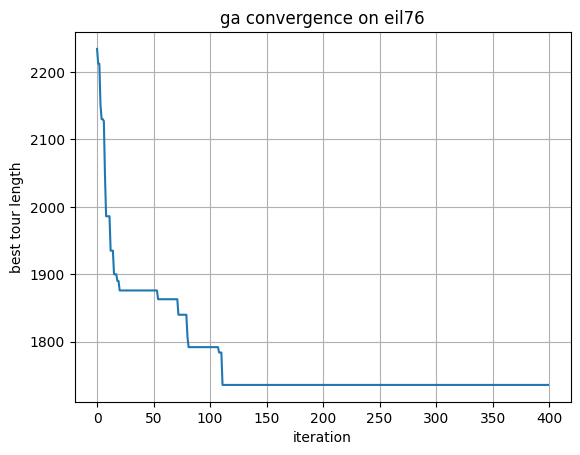

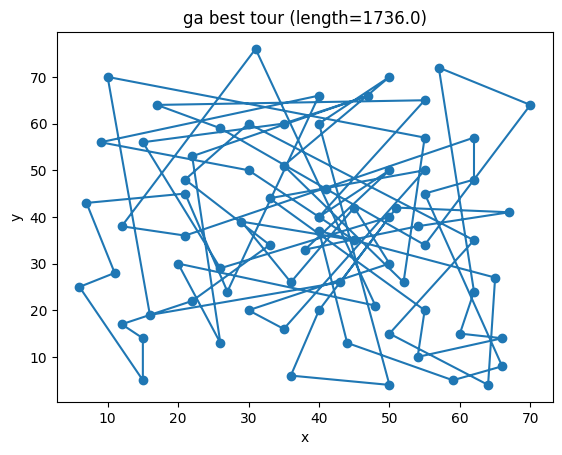

In [8]:
def plot_convergence(history, title="convergence"):
    plt.figure()
    plt.plot(history)
    plt.xlabel("iteration")
    plt.ylabel("best tour length")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_convergence(history_ga, "ga convergence on eil76")
plot_tour(best_tour_ga, coords, f"ga best tour (length={best_len_ga:.1f})")

In [9]:
# ant colony optimization for tsp

num_cities = len(coords)

def construct_ant_tour(dist_matrix, pheromone, alpha=1.0, beta=5.0):
    """
    builds a tour for one ant using the probabilistic transition rule
    """
    n = dist_matrix.shape[0]
    start_city = random.randint(0, n - 1)
    tour = [start_city]
    unvisited = set(range(n))
    unvisited.remove(start_city)

    while unvisited:
        i = tour[-1]

        # compute probabilities for next city
        probs = []
        for j in unvisited:
            tau_ij = pheromone[i, j] ** alpha
            eta_ij = (1.0 / (dist_matrix[i, j] + 1e-9)) ** beta
            probs.append((j, tau_ij * eta_ij))

        total = sum(p for _, p in probs)
        if total == 0:
            next_city = random.choice(list(unvisited))
        else:
            r = random.random() * total
            cum = 0.0
            next_city = None
            for j, p in probs:
                cum += p
                if r <= cum:
                    next_city = j
                    break

        tour.append(next_city)
        unvisited.remove(next_city)

    return tour

def update_pheromones(pheromone, ant_tours, ant_lengths, rho=0.5, Q=100.0):
    """
    evaporate old pheromone and add new pheromone from ants
    """
    # evaporation
    pheromone *= (1.0 - rho)

    # deposit pheromones from each ant
    for tour, L in zip(ant_tours, ant_lengths):
        deposit = Q / L
        for i in range(len(tour)):
            j = (i + 1) % len(tour)
            a = tour[i]
            b = tour[j]
            pheromone[a, b] += deposit
            pheromone[b, a] += deposit  # symmetric tsp

def run_aco(
    dist_matrix,
    num_ants=30,
    iterations=250,
    alpha=1.0,
    beta=5.0,
    rho=0.5,
    Q=100.0,
):
    """
    main aco loop: build tours, update pheromones, track best tour
    """
    n = dist_matrix.shape[0]
    # initial pheromone level based on average distance
    tau0 = 1.0 / (n * np.mean(dist_matrix[dist_matrix > 0]))
    pheromone = np.full((n, n), tau0)

    best_tour = None
    best_len = float("inf")
    best_lengths = []

    for it in range(iterations):
        ant_tours = []
        ant_lengths = []

        # each ant builds a tour
        for _ in range(num_ants):
            tour = construct_ant_tour(dist_matrix, pheromone, alpha=alpha, beta=beta)
            L = tour_length(tour, dist_matrix)
            ant_tours.append(tour)
            ant_lengths.append(L)

            if L < best_len:
                best_len = L
                best_tour = tour[:]

        best_lengths.append(best_len)

        # update pheromone trails
        update_pheromones(pheromone, ant_tours, ant_lengths, rho=rho, Q=Q)

        if it % 25 == 0 or it == iterations - 1:
            print(f"iteration {it+1}/{iterations} - best length so far: {best_len}")

    return best_tour, best_len, best_lengths

best_tour_aco, best_len_aco, history_aco = run_aco(distance_matrix)
print("aco best length:", best_len_aco)

iteration 1/250 - best length so far: 679.0
iteration 26/250 - best length so far: 572.0
iteration 51/250 - best length so far: 572.0
iteration 76/250 - best length so far: 569.0
iteration 101/250 - best length so far: 569.0
iteration 126/250 - best length so far: 569.0
iteration 151/250 - best length so far: 569.0
iteration 176/250 - best length so far: 563.0
iteration 201/250 - best length so far: 563.0
iteration 226/250 - best length so far: 563.0
iteration 250/250 - best length so far: 555.0
aco best length: 555.0


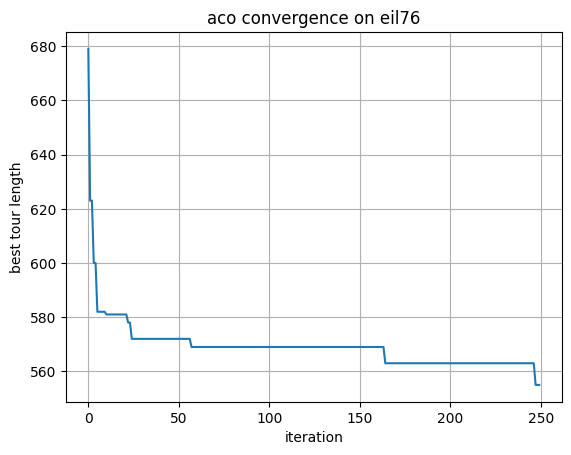

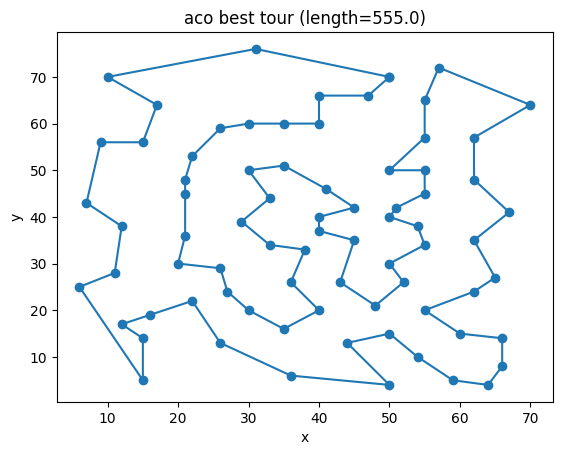

In [11]:
# aco conv
plot_convergence(history_aco, "aco convergence on eil76")

# aco best tour
plot_tour(best_tour_aco, coords, f"aco best tour (length={best_len_aco:.1f})")

GA Best Tour Length: 1736.0
ACO Best Tour Length: 555.0


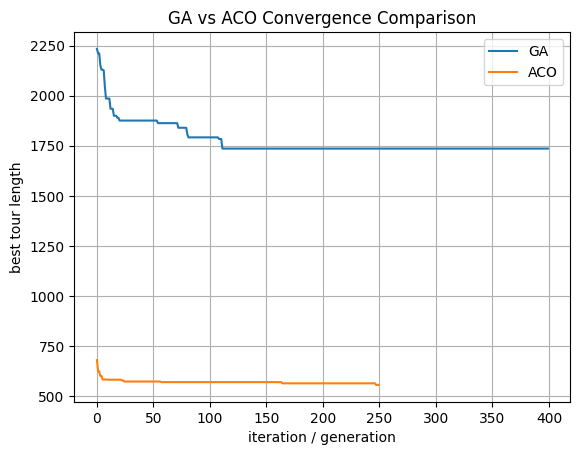

In [13]:
# final comparison section

print("GA Best Tour Length:", best_len_ga)
print("ACO Best Tour Length:", best_len_aco)

plt.figure()
plt.plot(history_ga, label="GA")
plt.plot(history_aco, label="ACO")
plt.xlabel("iteration / generation")
plt.ylabel("best tour length")
plt.title("GA vs ACO Convergence Comparison")
plt.legend()
plt.grid(True)
plt.show()



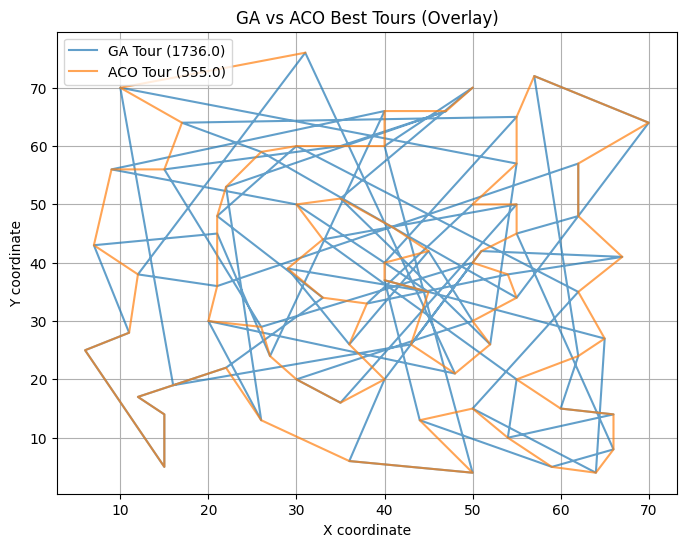

In [18]:
import numpy as np

best_tour_ga = np.array(best_tour_ga)
best_tour_aco = np.array(best_tour_aco)

plt.figure(figsize=(8,6))
coords_np = np.array(coords)

# GA tour
ga_x = coords_np[best_tour_ga, 0]
ga_y = coords_np[best_tour_ga, 1]
plt.plot(ga_x, ga_y, label=f"GA Tour ({best_len_ga:.1f})", alpha=0.7)

# ACO tour
aco_x = coords_np[best_tour_aco, 0]
aco_y = coords_np[best_tour_aco, 1]
plt.plot(aco_x, aco_y, label=f"ACO Tour ({best_len_aco:.1f})", alpha=0.7)

plt.title("GA vs ACO Best Tours (Overlay)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.grid(True)
plt.show()